In [1]:
import pandas as pd
from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC
import os


folder = "../KOI_Data/sample/"

fits_available = os.listdir(folder)
fits_available[:3]

['kplr001025986-20160128150956_dvt.fits',
 'kplr002013883-20160128150956_dvt.fits',
 'kplr001026032-20160128150956_dvt.fits']

In [2]:
def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()


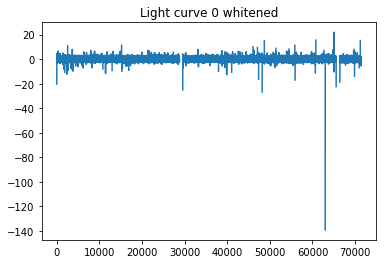

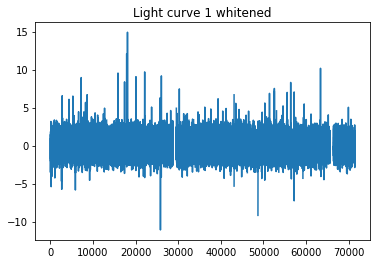

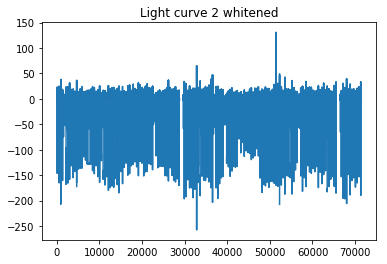

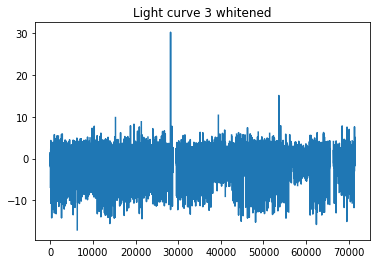

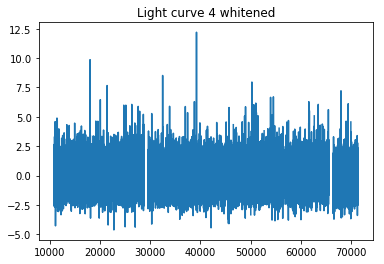

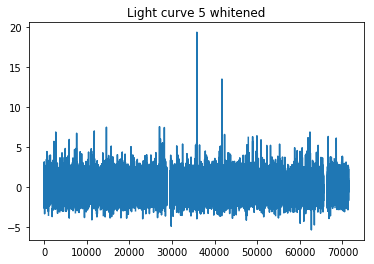

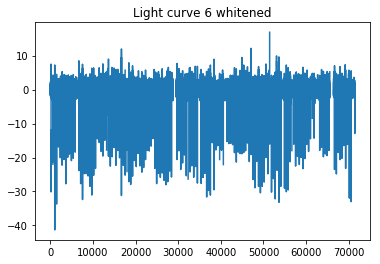

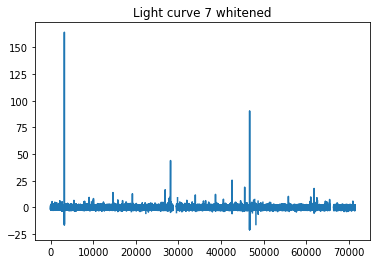

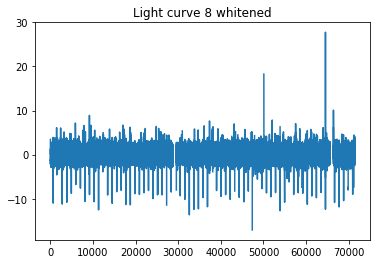

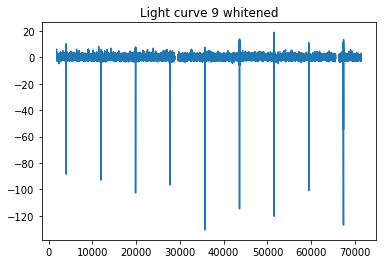

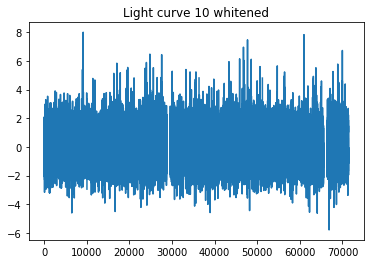

In [5]:
for i in range(11):
    hdulist = fits.open(folder+fits_available[i])
    #hdulist.info()
    data = hdulist[1].data
    lc_white = data.field("LC_WHITE")
    lc_detrend = data.field("LC_DETREND")
    
    plt.plot(lc_white)
    plt.title("Light curve "+str(i)+" whitened")
    plt.show()

array([ 131.51266094,  131.53309564,  131.55353023, ..., 1590.96061377,
       1590.9810483 , 1591.00148304])

In [195]:
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states
    M = [[0]*n for _ in range(n)]
    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1
    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

In [196]:
curva=[1,2,4,6,7,4,2,4,6,8,5,3,2,3,5,7,6,4,2]
m = transition_matrix(curva)
for row in m: 
    print(' '.join('{0:.2f}'.format(x) for x in row))

0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.33 0.67 0.00 0.00 0.00 0.00
0.00 0.00 0.50 0.00 0.00 0.50 0.00 0.00 0.00
0.00 0.00 0.50 0.00 0.00 0.00 0.50 0.00 0.00
0.00 0.00 0.00 0.50 0.00 0.00 0.00 0.50 0.00
0.00 0.00 0.00 0.00 0.33 0.00 0.00 0.33 0.33
0.00 0.00 0.00 0.00 0.50 0.00 0.50 0.00 0.00
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00


## My MTF

In [ ]:
def to_bins(curva, bins):
    minimo=np.nanmin(curva)
    maximo=np.nanmax(curva)
    ventana=(maximo-minimo)/bins
    bloques=[]
    
    
    return bloques

### HMM

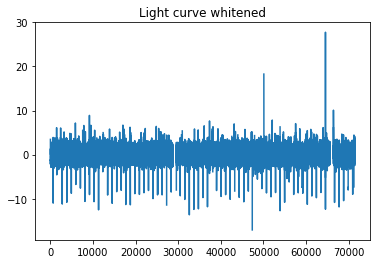

In [20]:
hdulist = fits.open(folder+fits_available[8])
data = hdulist[1].data
lc_white = data.field("LC_WHITE")
lc_detrend = data.field("LC_DETREND")

plt.plot(lc_white)
plt.title("Light curve whitened")
plt.show()

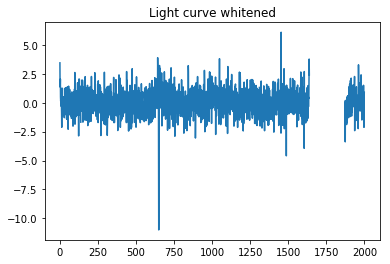

In [21]:
plt.plot(lc_white[:2000])
plt.title("Light curve whitened")
plt.show()

In [22]:
lc_init_cleaned=np.nan_to_num(lc_white[:2000]) #### replace nans
new_lc=[[cur] for cur in lc_init_cleaned]

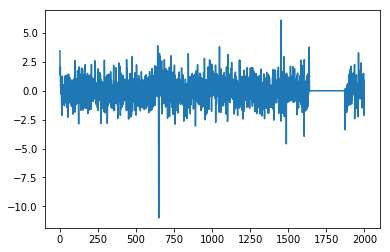

In [23]:
plt.plot(new_lc)

In [11]:
total=0
for new in new_lc:
    if np.isnan(new)[0]:
        total+=1
        print ("nan")
total

0

Log-likehood con 5  estados del conjunto de entrenamiento -1640.7042024620062


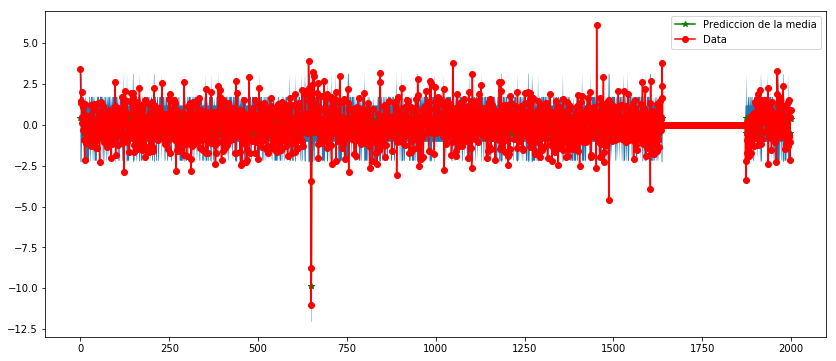

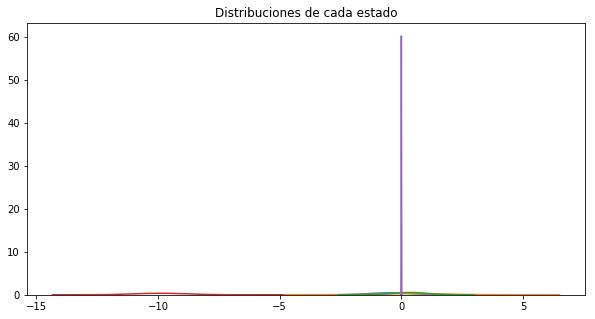

Log-likehood con 10  estados del conjunto de entrenamiento -1610.3659988230627


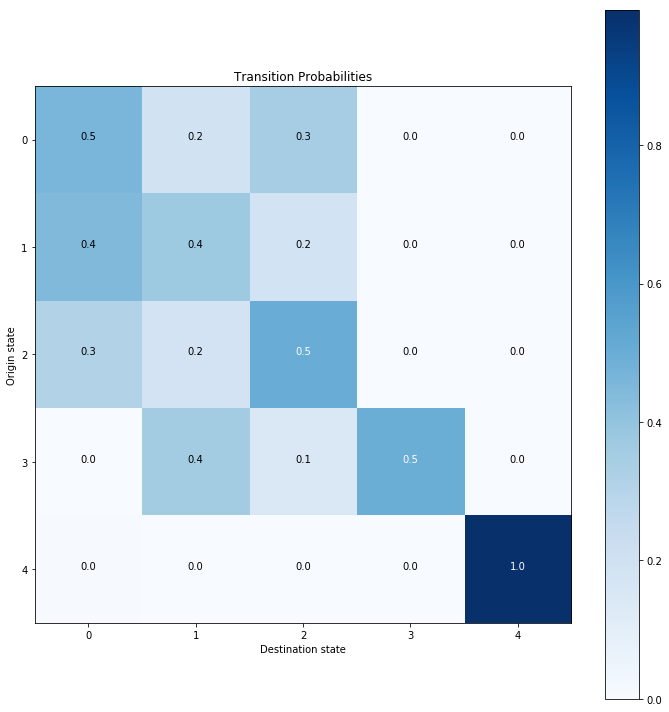

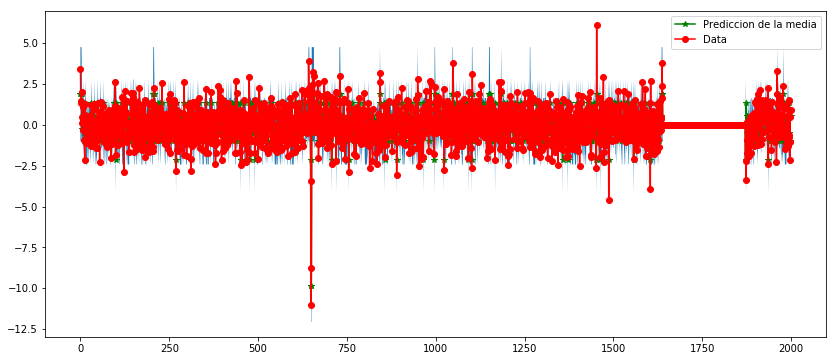

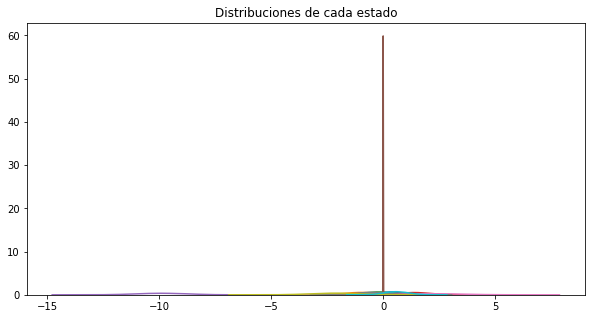

Log-likehood con 20  estados del conjunto de entrenamiento -1577.8128984446128


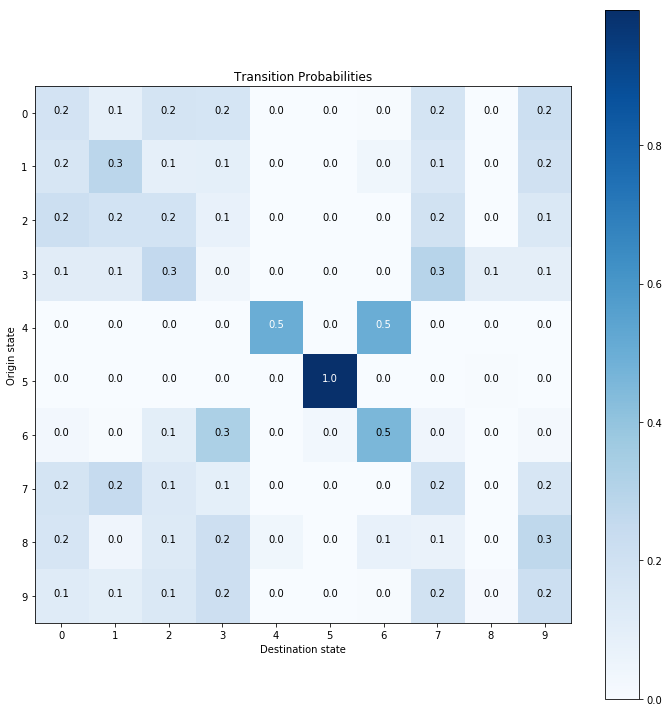

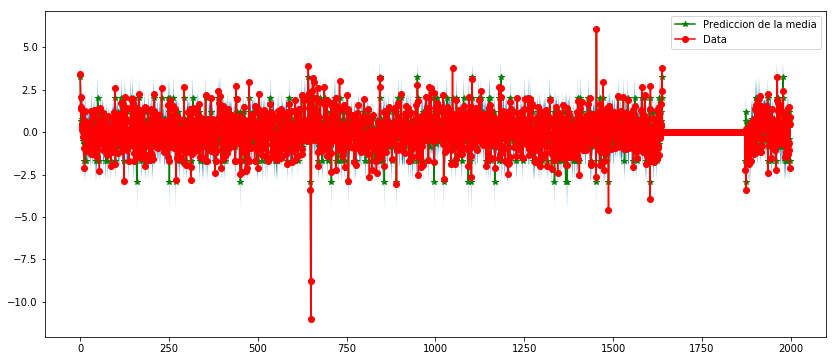

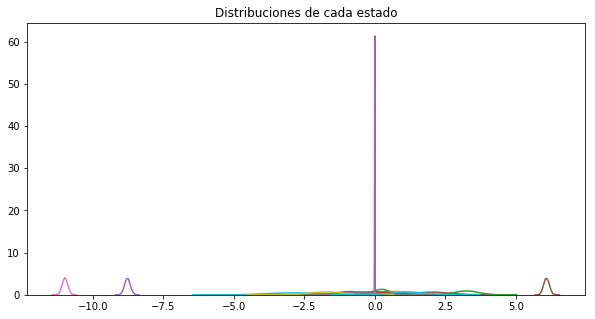

Log-likehood con 40  estados del conjunto de entrenamiento -1540.8812141465096


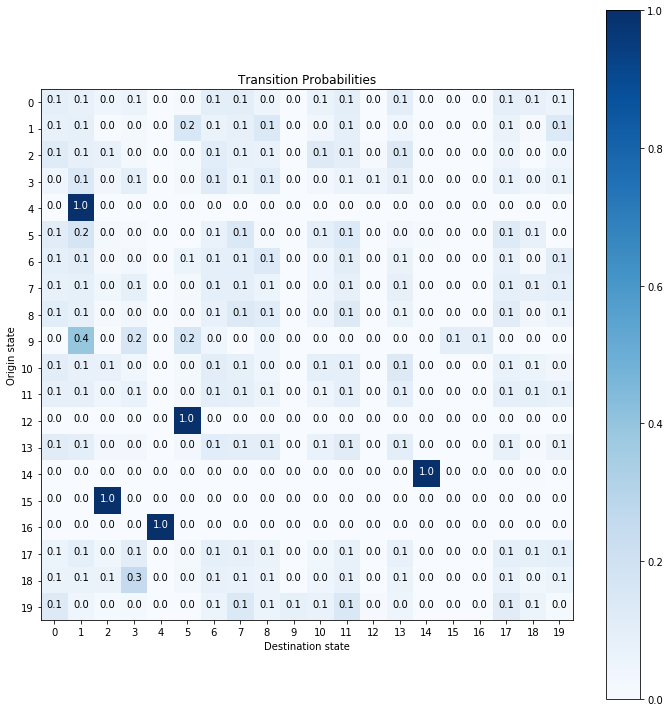

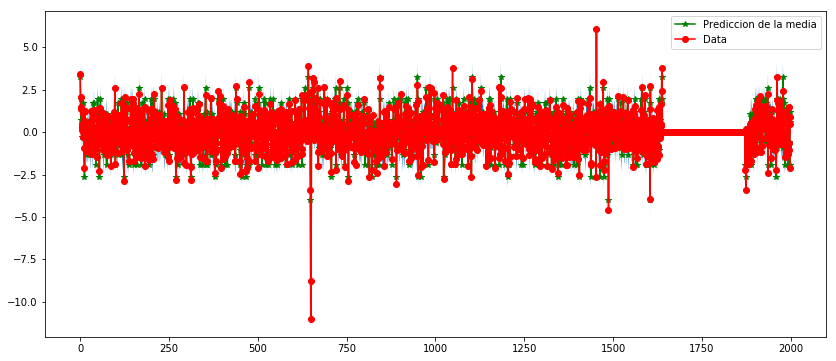

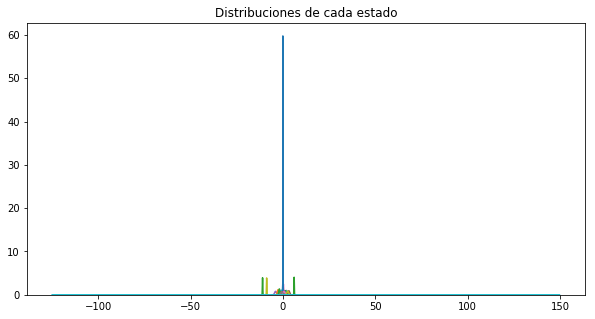

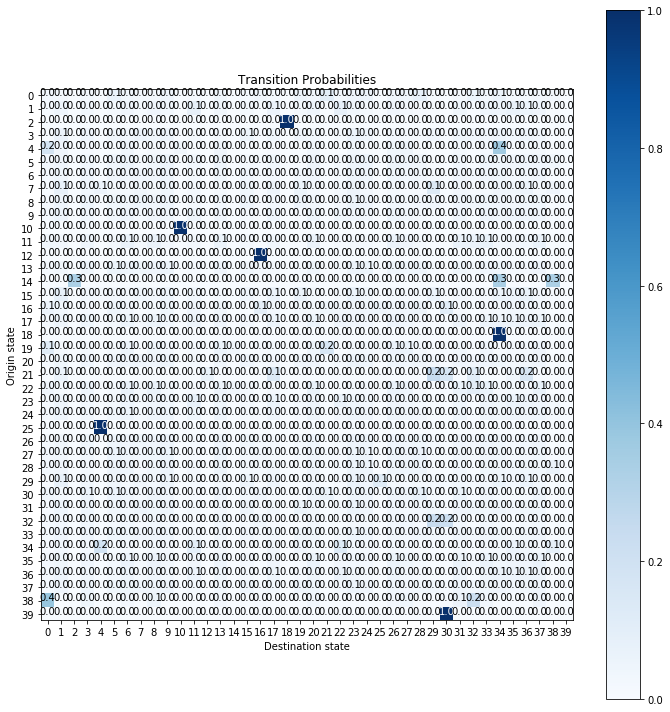

In [26]:
n_state = [5,10,20,40]
for n_sta in n_state:
    markov_model = hmm.GaussianHMM(n_components=n_sta, n_iter=50)
    markov_model.fit(new_lc)
    print("Log-likehood con",n_sta," estados del conjunto de entrenamiento",markov_model.score(new_lc)) 
    
    X_state = markov_model.predict(new_lc) #predice el estado, no el valor 
    plt.figure(figsize=(14,6))
    plt.fill_between(np.arange(np.asarray(new_lc).shape[0]),
                     markov_model.means_[X_state][:,0]-1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0],
                     markov_model.means_[X_state][:,0]+1.96*np.sqrt(markov_model.covars_[X_state])[:,0,0]) 
    plt.plot(markov_model.means_[X_state][:,0],'g*-',label="Prediccion de la media") 
    plt.plot(new_lc,'ro-',label="Data") #-- here put train or val plt.legend() plt.show()
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    for i in range(n_sta):
        r = norm(markov_model.means_[i], np.sqrt( markov_model.covars_[i,0])).rvs(10000)
        sns.distplot(r,kde=True, hist=False)

    plt.title("Distribuciones de cada estado")
    plt.show()
    plot_state_matrix(markov_model.transmat_,np.arange(n_sta))